# Image Classification experiment for CIFAR-10 dataset 

CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html)contains 60,000 32*32 color images in 10 classes, with 6000 images per class. Your task is to build a multiclass image classifier using 2D Convolutional Neural Networks (CNNs) to achieve the best possible classification accuracy for the training set.   




In [1]:
#Importing required python packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import resnet
import simple_net
import simple_net_bn

#Define the mini-batch size
batch_size = 128

In [2]:
# Assing CUDA device for computations:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [2]:
#Define data transformation 

#transformation for training image set
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

#transformation for testing image set
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])


In [3]:
#Loading the dataset 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
#Find the dataset sizes and number of batches

#train set size
train_set_size = len(trainset)

#Number of mini-batches in trainset 
train_batches = len(trainloader)

print("Train set size : " + str(train_set_size))
print("Training batches : " + str(train_batches))

Train set size : 50000
Training batches : 391


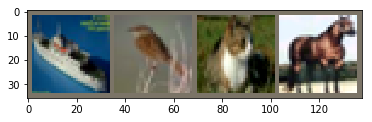

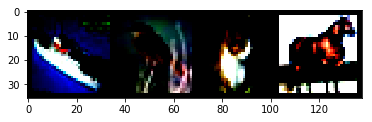

 ship  bird   cat horse


In [6]:
#Visualize 4 random training images
viewloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# get some random training images
dataiter = iter(viewloader)
images, labels = dataiter.next()

# functions to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#Visualize 4 random training images with transformations
def imshowtransform(inp,title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# show images
imshow(torchvision.utils.make_grid(images))
imshowtransform(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [26]:
#Initiating networks
simplenet = simple_net.SimpleNet()
simplenet_bn = simple_net_bn.SimpleNet_bn()
resnet34 = resnet.ResNet34()

net = simplenet_bn.to(device)

print(net)

SimpleNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [27]:
#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

#Define the optimizer and the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [31]:
#lists for generating graphs
epochs = list()
training_loss = list()

# loop over the dataset multiple times
for epoch in range(8):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[Epoch : %d] train_loss: %.3f' %
          (epoch + 1, running_loss / train_batches))
    epochs.append(epoch)
    training_loss.append(running_loss/train_batches)
    running_loss = 0.0

print('Finished Training')

[Epoch : 1] train_loss: 1.365
[Epoch : 2] train_loss: 1.366
[Epoch : 3] train_loss: 1.361
[Epoch : 4] train_loss: 1.345
[Epoch : 5] train_loss: 1.329
[Epoch : 6] train_loss: 1.325
[Epoch : 7] train_loss: 1.315
[Epoch : 8] train_loss: 1.320
Finished Training
[0, 1, 2, 3, 4, 5, 6, 7]


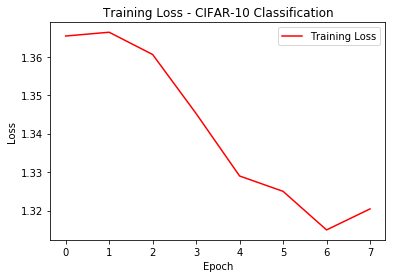

In [33]:
#Plot the epoch vs. training loss
plt.figure(1)
plt.title("Training Loss - CIFAR-10 Classification")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs, training_loss, color='r', label="Training Loss")
plt.legend()
plt.show()

In [35]:
#Saving trained model
#torch.save(net.state_dict(), "trained_resnet_model.pth")

#Loading the model
model = resnet.ResNet34().to(device)
model.load_state_dict(torch.load("trained_resnet_model.pth"))

In [37]:
#Testing the trained model with training data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 89 %


In [88]:
#Evaluate the class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 61 %
Accuracy of  deer : 88 %
Accuracy of   dog : 87 %
Accuracy of  frog : 88 %
Accuracy of horse : 88 %
Accuracy of  ship : 96 %
Accuracy of truck : 89 %


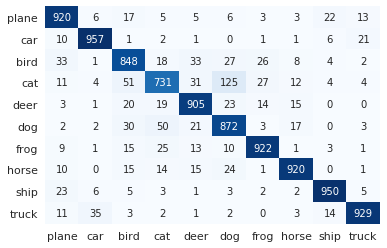

In [89]:
#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(10)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    #print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in classes], columns = [i for i in classes])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 